In [3]:
#-----------------------------------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
import time as t
from datetime import datetime, timedelta, date 
from dateutil.relativedelta import *
from netCDF4 import Dataset   
import glob
import requests 
import pandas as pd
import xarray as xr
import requests 
import functools
import operator
import wget
import os
import gc
import numpy as np
import pygrib
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
import datetime as dt
import holidays


import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import shapefile
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy, cartopy.crs as ccrs   
import regionmask
from shapely.geometry import Point, Polygon

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker 
import scipy.ndimage as ndimage
from PIL import Image
from scipy.ndimage import gaussian_filter

import scipy.ndimage

from google.cloud import storage, bigquery

In [4]:
#Diretórios 

root='/mnt/c/scripts/temas/consultas'

# direc='/mnt/c/scripts/Disp_carga_e_temp'

carga = pd.read_parquet(f'{root}/carga.pq')

samet = pd.read_parquet(f'{root}/temp_submarket.pq')



dict_submarket = {'Nordeste':'NE', 
                'SUDESTE/CENTRO-OESTE':'SECO',
                'Sudeste':'SECO',
                'Norte':'N', 
                'Sul':'S',
                'NORDESTE':'NE', 
                'SUDESTE':'SECO',
                'NORTE':'N', 
                'SUL':'S',
                'SE/CO':'SECO'}



#Modifica os nomes das colunas para o merge, retirando programado e os outros tipos de carga 

carga = carga.query('tipo== "Carga"').rename({'data':'data','submercado':'submarket'},axis=1).drop(['tipo'],axis=1).reset_index(drop=True)

carga['submarket']= carga['submarket'].replace(to_replace =dict_submarket) 


carga.sort_values(by=['data','submarket'])


samet_1 = samet.rename({'date_ref': 'data'},axis =1)


df = carga.merge(samet_1, on=['data','submarket']).sort_values(by=['data','submarket']).reset_index(drop=True)


df['data'] = pd.to_datetime(df['data'])

#Filtragem apagão e pandemia 
df_f = df.drop(df.query('(data > "2001-05-01" and data < "2002-12-01") or (data > "2020-03-01" and data < "2020-10-01")').index).sort_values('data')

df_f.data.dt.weekday.drop_duplicates()

df_f['semana']= df_f['data'].dt.dayofweek

In [5]:
df_f

,data,submarket,verificado,mean_temperature,mean_temperature_pop,mean_temperature_ons,semana
0,2000-01-01,N,2243.512500,25.606749,26.199050,26.537545,5
1,2000-01-01,NE,4646.370833,25.616585,25.969045,26.802860,5
2,2000-01-01,S,4800.650000,21.590355,21.320426,22.810989,5
3,2000-01-01,SECO,19045.995833,22.926514,23.092016,24.366314,5
4,2000-01-02,N,2259.808333,25.504232,26.020317,26.785737,6
...,...,...,...,...,...,...,...
33970,2023-04-02,S,9358.000000,19.018627,18.844361,18.815540,6
33973,2023-04-03,NE,11603.000000,25.491495,26.138750,27.529200,0
33974,2023-04-03,S,12602.000000,20.773202,20.166920,19.744242,0
33972,2023-04-03,N,6857.000000,25.113012,25.397297,27.233374,0


Funções

In [6]:
def converter_para_booleano(valor):
    if valor != 5 and valor != 6:
        return True
    else:
        return False
    

def classificar_entre_linhas(df, coluna_dias_util, coluna_holy, coluna_classe):
    
    df[coluna_classe] = 'Não Classificado'  # padrão
    
    for i in range(1, len(df) - 1):

          #Dia anterior  
          dia_anterior = df.loc[i - 1, coluna_dias_util]
          holy_anterior = df.loc[i - 1, coluna_holy]

          #Dia posterior  
          dia_posterior = df.loc[i + 1, coluna_dias_util]
          holy_posterior = df.loc[i + 1, coluna_holy]
          
          #Dia atual    
          dia_atual = df.loc[i, coluna_dias_util]
          holy_atual = df.loc[i, coluna_holy]


     # CLASSE E

          if (dia_atual == False or holy_atual == True):
               df.loc[i, coluna_classe] = 'E'
          
     # CLASSE C 

          elif  (dia_anterior == False or holy_anterior == True) and (dia_atual==True and holy_atual==False) and (dia_posterior == False or holy_posterior == True):
               df.loc[i, coluna_classe] = 'C'   


     # CLASSE A 
          elif (dia_atual == True or holy_atual ==False) and dia_posterior == False:
               df.loc[i, coluna_classe] = 'A'   


     #  CLASSE B 
          elif (dia_anterior == False or holy_anterior ==True) and dia_atual == True:
               df.loc[i, coluna_classe] = 'B'    
          
                    
     # CLASSE D
          elif (dia_atual == True or holy_atual == False):
               df.loc[i, coluna_classe] = 'D'

    
    return df
    
    


In [7]:
# ----MUDAR O SUBMERCADO---------------------


final_data = []
submercados = ["SECO", "S","NE","N"]

for sub in submercados:
    
    
    SUB = df_f.query('submarket == @sub')
    #carga média por todos os dias do ano
    pm_y = SUB.groupby(SUB.data.dt.year).agg({'verificado': np.average}) 


    # consumo médio de energia do cada dia da semana correspondente a cada ano
    pm_yj = SUB.groupby([SUB.semana, SUB.data.dt.year])['verificado'].mean()

    df1 = pm_yj.to_frame().reset_index()

    df2= pm_y.reset_index()

    df_merge = df1.merge(df2,on='data')

    df_merge = df_merge.rename({'verificado_x':'pm_yj','verificado_y':'pm_y','data':'year'},axis=1)



    #-----------P1---------------------------------------
     #Retira a tendência semanal 

    df_merge['div'] = df_merge.pm_yj / df_merge.pm_y

    alpha = df_merge.groupby('semana')['div'].mean()

    df_r = SUB.merge(alpha, on=['semana']).sort_values(by=['data','semana']).reset_index(drop=True)

    df_r = df_r.rename({'div':'alpha_j'},axis=1)

    df_r['data'] = pd.to_datetime(df_r['data'])


    #Série sem tendência 
    df_r['P1'] = df_r['verificado'] / df_r['alpha_j']






    #---------------------------------------------------------------- 
    #             Agrupamento de Classes
    #----------------------------------------------------------------
    feriados= holidays.Brazil()

    list_feriado = []
        
    for feriado in feriados['2000-01-01': '2023-04-03'] :
        list_feriado.append(feriado)

    df_r.reset_index().sort_index()

    clas_day = df_r['data'].isin(list_feriado) #checa se existem feriados por true/false

    df_r['holy'] = clas_day

    df_r['dia_util'] = df_r['semana'].apply(converter_para_booleano)

    df = df_r.copy()


    #Classificação em A,B,C, e D
    df = classificar_entre_linhas(df_r, 'dia_util', 'holy', 'classe')

    # print(sub, df)

    #Correção dos extremos na mão 
    df.loc[0, 'classe'] = df.loc[0, 'classe'].replace('Não Classificado', 'E') 
    df.loc[7702, 'classe'] = df.loc[7702, 'classe'].replace('Não Classificado', 'D') 

    
    
    
    
    #-----------P2---------------------------------------
    #Fazer a média de P1_wj para cada classe (a,b...) e semana (0,1.....,6) -P1m(y)
    P1_my = df.P1.groupby([df.data.dt.year]).mean()
    P1_my.to_frame().reset_index('data')


    # #P1_yt --> consumo médio de energia correspondente a classe por ano 
    P1_yt = df.groupby([df.classe, df.data.dt.year])['P1'].mean()


    df1 = P1_my.to_frame().reset_index()
    df2= P1_yt.reset_index()


    df_merge = df1.merge(df2,on=['data'])
    df_merge = df_merge.rename({'P1_x':'P1_my','P1_y':'P1','data':'year'},axis=1)


    df_merge['div'] = df_merge.P1 / df_merge.P1_my

    alpha_t = df_merge.groupby('classe')['div'].mean()

    df_fim = df.merge(alpha_t, on=['classe']).sort_values(by=['data']).reset_index(drop=True)

    df_fim = df_fim.rename({'div':'alpha_t'},axis=1)

    
    
    #Série sem tendência 
    df_fim['P2'] = df_fim.P1 / df_fim.alpha_t

    # df_fim.alpha_t.describe()






    #---------------------------------------------------------------- 
    #            Agrupamento por dias do ano
    #----------------------------------------------------------------
    df_fim['day_of_year']= df_fim['data'].dt.day_of_year #agruda dias a cada ano 

    #P3m(y) is the power for dayofyear   of yth year
    p3m_y = df_fim.groupby([df_fim.day_of_year, df_fim.data.dt.year])['P2'].mean()

    # # Pm(y) --> carga média por todos os dias do ano
    pm_y = df_fim.groupby(df_fim.data.dt.year).agg({'P2': np.average}) 



    df1 = p3m_y.to_frame().reset_index()

    df2= pm_y.reset_index()

    df_merge_sesonal = df1.merge(df2,on='data')

    df_merge_sesonal = df_merge_sesonal.rename({'P2_x':'p3m_y','P2_y':'pm_y','data':'year'},axis=1)




    #-----------P3---------------------------------------


    df_merge_sesonal['div'] = df_merge_sesonal.p3m_y / df_merge_sesonal.pm_y

    alpha_d = df_merge_sesonal.groupby([df_merge_sesonal.day_of_year])['div'].mean()

    df_detrend = df_fim.merge(alpha_d, on=['day_of_year']).sort_values(by=['day_of_year']).reset_index(drop=True)

    df_detrend = df_detrend.rename({'div':'alpha_d'},axis=1)

    
    
    
    #Série sem tendência
    df_detrend['P3'] = df_detrend.P2 / df_detrend.alpha_d



    
    final_data.append(df_detrend)      

In [8]:
final_data[0]

,data,submarket,verificado,mean_temperature,mean_temperature_pop,mean_temperature_ons,semana,alpha_j,P1,holy,dia_util,classe,alpha_t,P2,day_of_year,alpha_d,P3
0,2000-01-01,SECO,19045.995833,22.926514,23.092016,24.366314,5,0.957259,19896.387479,True,False,E,0.985666,20185.738060,1,0.810037,24919.524756
1,2023-01-01,SECO,31053.000000,23.732126,23.594666,25.424474,6,0.862810,35990.541241,True,False,E,0.985666,36513.947012,1,0.810037,45076.885660
2,2022-01-01,SECO,31511.000000,23.022149,23.023885,23.883129,5,0.957259,32917.946183,True,False,E,0.985666,33396.667603,1,0.810037,41228.568537
3,2021-01-01,SECO,32385.000000,24.285439,24.349799,24.935345,4,1.039947,31141.020166,True,True,E,0.985666,31593.899981,1,0.810037,39003.031267
4,2020-01-01,SECO,32471.000000,25.408039,26.028711,27.850511,2,1.044209,31096.261695,True,True,E,0.985666,31548.490594,1,0.810037,38946.972858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7698,2000-12-31,SECO,22007.156250,23.751911,23.450077,25.015656,6,0.862810,25506.375056,True,False,E,0.985666,25877.310959,366,0.924396,27993.746925
7699,2004-12-31,SECO,25219.304999,24.675628,25.119795,26.163110,4,1.039947,24250.575438,True,True,E,0.985666,24603.248410,366,0.924396,26615.482211
7700,2008-12-31,SECO,26155.603333,24.784399,24.755554,26.116570,2,1.044209,25048.242618,True,True,E,0.985666,25412.515960,366,0.924396,27490.937588
7701,2012-12-31,SECO,31708.199250,24.721343,25.188184,25.936004,0,1.014081,31267.922701,True,True,E,0.985666,31722.648044,366,0.924396,34317.158477


In [9]:
SECO = final_data[0]
S = final_data[1]
NE = final_data[2]
N = final_data[3]
files=[SECO,S,NE,N]

In [10]:

N.columns

Index(['data', 'submarket', 'verificado', 'mean_temperature',
       'mean_temperature_pop', 'mean_temperature_ons', 'semana', 'alpha_j',
       'P1', 'holy', 'dia_util', 'classe', 'alpha_t', 'P2', 'day_of_year',
       'alpha_d', 'P3'],
      dtype='object')

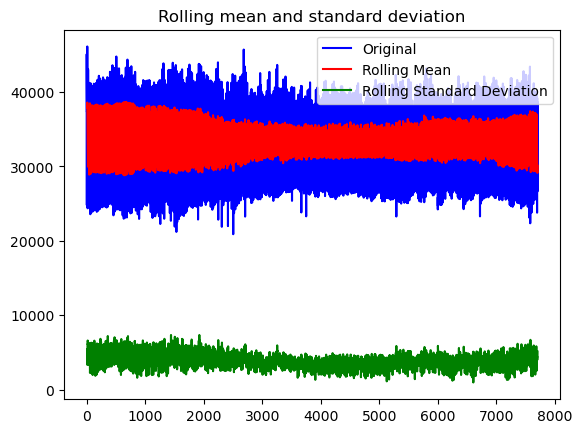

ADF Statistic: -12.555390
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary








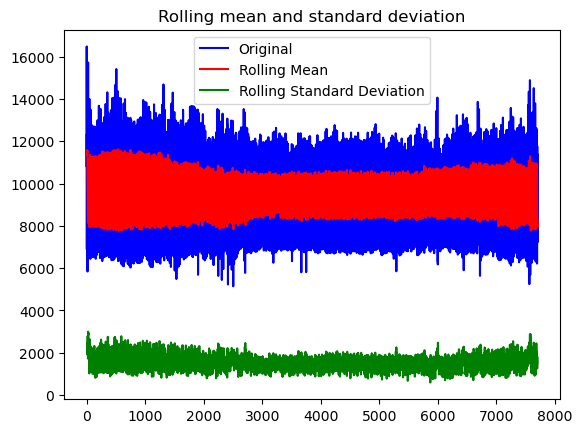

ADF Statistic: -9.990654
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary








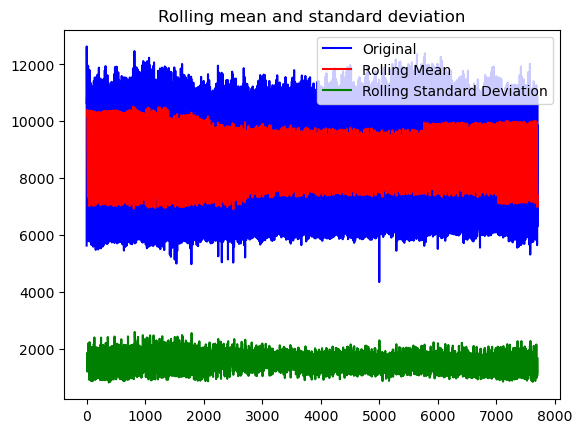

ADF Statistic: -11.996726
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary








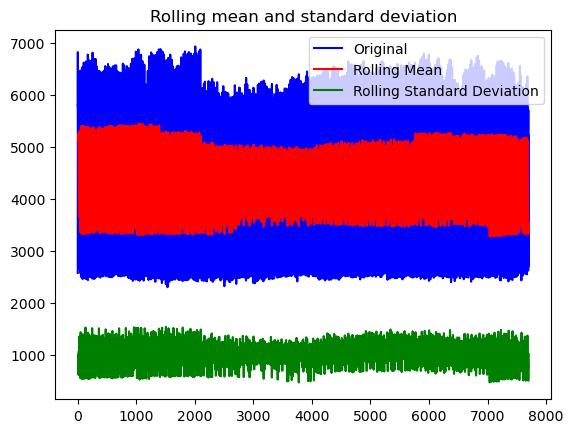

ADF Statistic: -12.020790
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary








In [11]:
   
for i in files: 

    rmean=i.P3.rolling(window=12).mean()
    rstd=i.P3.rolling(window=12).std()
    # print(rmean,rstd)
    orig=plt.plot(i.P3 , color='blue',label='Original')
    mean= plt.plot(rmean , color='red',label='Rolling Mean')
    std=plt.plot(rstd,color='green',label = 'Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title("Rolling mean and standard deviation")
    plt.show(block=False)
   


    X = i.P3
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

    print('\n')
    print('\n')
    print('\n')


In [12]:
# SECO = final_data[0].set_index("mean_temperature").sort_index().reset_index(drop=False) 
# S = final_data[1].set_index("mean_temperature").sort_index().reset_index(drop=False) 
# NE = final_data[2].set_index("mean_temperature").sort_index().reset_index(drop=False) 
# N = final_data[3].set_index("mean_temperature").sort_index().reset_index(drop=False) 
# files=[SECO,S,NE,N]


# lista_reg = files
# reg_names = ['SECO','S','NE','N']

# fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8),sharex = False)
# plt.subplots_adjust(hspace=0.50)
# #plt.subplots_adjust(wspace=0.08)

# fig.suptitle("Elasticidade de Carga com mean_temperature de 2000 e 2023", fontsize=12, y=0.95)

# count=0
 
# for i in range(2):

#     for j in range(2):

#         ax[i,j].plot(lista_reg[count].mean_temperature,lista_reg[count].P3,color='lightgreen')  
#         ax[i,j].legend([ 'Carga sem Tendência'])
#         ax[i,j].set_title( 'Submercado: ' +reg_names[count] ,fontsize=9, loc='center')
            
        
#         ax[i,j].set_ylabel('Carga sem Tendência ($MWmed$)',fontsize=9)
#         ax[i,j].set_xlabel('Temperatura ($°C$)',fontsize=9) 
               
#         count += 1
                
               
#         if count == len(lista_reg):
#             break
                    
      
#     if count == len(lista_reg):
#         break


# plt.savefig('carga_temp.png')



PLOTS

In [13]:
files=[SECO,S,NE,N]

In [14]:
df_fim = pd.DataFrame()

for x in range(len(files)):

    df_new = files[x].set_index("mean_temperature").sort_index().reset_index(drop=False) #ordena o df de forma cresc e reseta o index


    for submercado in df_new.submarket.unique():

        frame =df_new.query('submarket == @submercado')
        
        frame = frame.reset_index(drop=True)

        X = frame.iloc[:, 0].values.reshape(-1, 1)          
        y = frame.iloc[:, 16].values.reshape(-1, 1)    # carga sem tendencia P3


    #Modelo Linear
    
        model = LinearRegression()
        
        model.fit(X, y)
            
        Y_pred_lin = model.predict(X)

        frame['Y_pred_lin'] = Y_pred_lin #curva para a previsão da carga sem tend com relação à mean_temperature



    # #Metodo Quadratico

        #X = frame.index.values.reshape(-1, 1)     
        
        pf = PolynomialFeatures(degree=2) #2 graus de liberdade
        
        Xp = pf.fit_transform(X) #normalização do dado entre desvio padrão e média 
        
        md2 = LinearRegression()
        md2.fit(Xp,  y)
        
        Y_pred_quad = md2.predict(Xp)
        min = np.min(Y_pred_quad)
        # print('Y_pred_quad min:',min)
        

        frame['Y_pred_quad'] = Y_pred_quad #curva 


        


    #Metodo Cúbico 

        pf = PolynomialFeatures(degree=3) #3 graus de liberdade
        Xp = pf.fit_transform(X)

            
        md3 = LinearRegression()
        md3.fit(Xp,  y)
        Y_pred_cub = md3.predict(Xp)
        
        # print('Y_pred_cub min:',min)


        frame['Y_pred_cub'] = Y_pred_cub #curva 
        
        
        # # max_y = np.min(Y_pred_cub)
        # # loc = np.where(Y_pred_cub == max_y)
        #         # print('Ponto max:', max )
        # # print('Ponto  x:', loc )
        # # print('\n')
       
       
        # ymax = Y_pred_cub[np.argmax(y)]
        # xmax = y.max()
        # print('Ponto max:', ymax )
        # print('Ponto  x:', xmax )
        # # print('\n')





        df_fim = pd.concat([df_fim, frame], axis=0)

In [15]:
df_fim = df_fim.sort_index().reset_index(drop=False) 
SECO= df_fim.query('submarket == "SECO"')
N=df_fim.query('submarket == "N"')
NE=df_fim.query('submarket == "NE"')
S=df_fim.query('submarket == "S"')

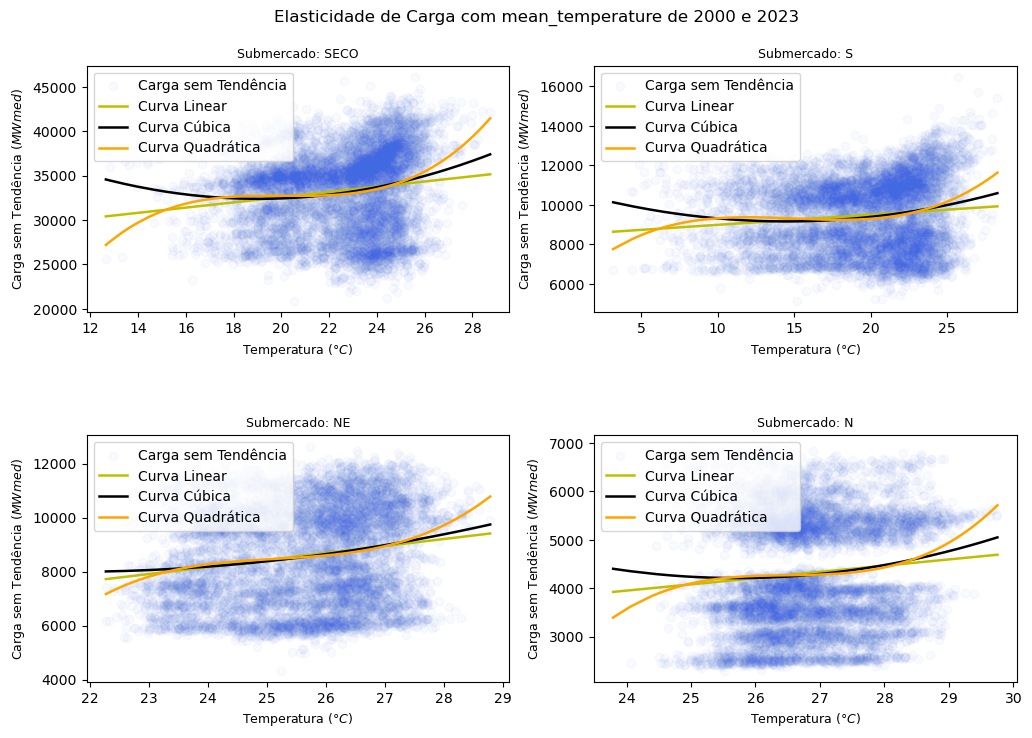

In [16]:
lista_reg = [SECO,S,NE,N]
reg_names = ['SECO','S','NE','N']

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8),sharex = False)
plt.subplots_adjust(hspace=0.50)
#plt.subplots_adjust(wspace=0.08)

fig.suptitle("Elasticidade de Carga com mean_temperature de 2000 e 2023", fontsize=12, y=0.95)

count=0
 
for i in range(2):

    for j in range(2):

        ax[i,j].scatter(lista_reg[count].mean_temperature,lista_reg[count].P3,color='royalblue',alpha=0.03)  
        ax[i,j].plot(lista_reg[count].mean_temperature,lista_reg[count].Y_pred_lin, linewidth=1.8,color='y')
        ax[i,j].plot(lista_reg[count].mean_temperature,lista_reg[count].Y_pred_quad,linewidth=1.8,color='black')
        ax[i,j].plot(lista_reg[count].mean_temperature,lista_reg[count].Y_pred_cub,linewidth=1.8,color='orange')
        # pylab.plot(x0,rsinc(x0),'bd',xmin0,rsinc(xmin0),'bo')
        ax[i,j].legend([ 'Carga sem Tendência','Curva Linear','Curva Cúbica','Curva Quadrática'])
        ax[i,j].set_title( 'Submercado: ' +reg_names[count] ,fontsize=9, loc='center')
            
        
        ax[i,j].set_ylabel('Carga sem Tendência ($MWmed$)',fontsize=9)
        ax[i,j].set_xlabel('Temperatura ($°C$)',fontsize=9) 
               
        count += 1
                
               
        if count == len(lista_reg):
            break
                    
      
    if count == len(lista_reg):
        break


plt.savefig('figs_teste1/mean_temperature_TESTE1.png',dpi=150)

mean_temperature_pop

In [17]:
df_fim = pd.DataFrame()

for x in range(len(files)):

    df_new = files[x].set_index("mean_temperature_pop").sort_index().reset_index(drop=False) #ordena o df de forma cresc e reseta o index


    for submercado in df_new.submarket.unique():

        frame =df_new.query('submarket == @submercado')
        
        frame = frame.reset_index(drop=True)

        X = frame.iloc[:, 0].values.reshape(-1, 1)     #     
        y = frame.iloc[:, 16].values.reshape(-1, 1)    # carga sem tendencia P3


    #Modelo Linear
    
        model = LinearRegression()
        
        model.fit(X, y)
            
        Y_pred_lin = model.predict(X)

        frame['Y_pred_lin'] = Y_pred_lin #curva para a previsão da carga sem tend com relação à mean_temperature



    # #Metodo Quadratico

        #X = frame.index.values.reshape(-1, 1)     
        
        pf = PolynomialFeatures(degree=2) #2 graus de liberdade
        
        Xp = pf.fit_transform(X) #normalização do dado entre desvio padrão e média 
        
        md2 = LinearRegression()
        md2.fit(Xp,  y)
        
        Y_pred_quad = md2.predict(Xp)

        frame['Y_pred_quad'] = Y_pred_quad #curva 


    #Metodo Cúbico 

        pf = PolynomialFeatures(degree=3) #3 graus de liberdade
        Xp = pf.fit_transform(X)

            
        md3 = LinearRegression()
        md3.fit(Xp,  y)
        Y_pred_cub = md3.predict(Xp)

        frame['Y_pred_cub'] = Y_pred_cub #curva 



        df_fim = pd.concat([df_fim, frame], axis=0)

In [18]:
df_fim = df_fim.sort_index().reset_index(drop=False) 
SECO= df_fim.query('submarket == "SECO"')
N=df_fim.query('submarket == "N"')
NE=df_fim.query('submarket == "NE"')
S=df_fim.query('submarket == "S"')

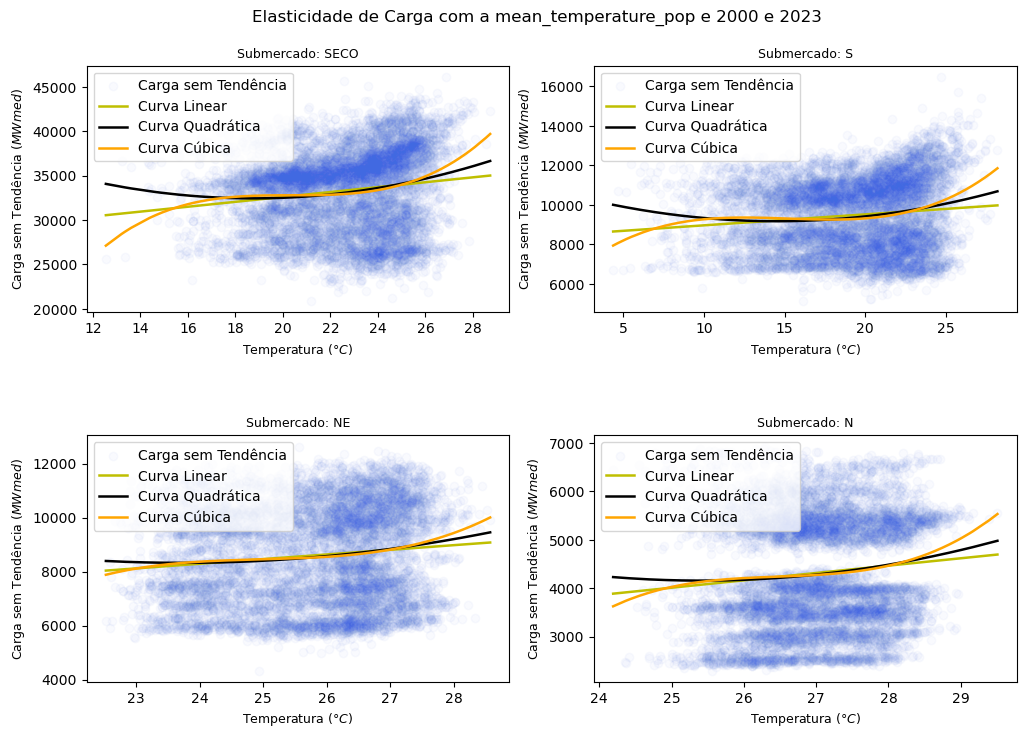

In [19]:
lista_reg = [SECO,S,NE,N]
reg_names = ['SECO','S','NE','N']

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8),sharex = False)
plt.subplots_adjust(hspace=0.50)
#plt.subplots_adjust(wspace=0.08)

fig.suptitle("Elasticidade de Carga com a mean_temperature_pop e 2000 e 2023", fontsize=12, y=0.95)

count=0
 
for i in range(2):

    for j in range(2):

        ax[i,j].scatter(lista_reg[count].mean_temperature_pop,lista_reg[count].P3,color='royalblue',alpha=0.03)  
        ax[i,j].plot(lista_reg[count].mean_temperature_pop,lista_reg[count].Y_pred_lin, linewidth=1.8,color='y')
        ax[i,j].plot(lista_reg[count].mean_temperature_pop,lista_reg[count].Y_pred_quad,linewidth=1.8,color='black')
        ax[i,j].plot(lista_reg[count].mean_temperature_pop,lista_reg[count].Y_pred_cub,linewidth=1.8,color='orange')
        ax[i,j].legend([ 'Carga sem Tendência','Curva Linear','Curva Quadrática','Curva Cúbica'],loc='upper left')
        ax[i,j].set_title( 'Submercado: ' +reg_names[count] ,fontsize=9, loc='center')
            
        
        ax[i,j].set_ylabel('Carga sem Tendência ($MWmed$)',fontsize=9)
        ax[i,j].set_xlabel('Temperatura ($°C$)',fontsize=9) 
               
        count += 1
                
               
        if count == len(lista_reg):
            break
                    
      
    if count == len(lista_reg):
        break


plt.savefig('figs_teste1/mean_temperature_pop_teste1.png',dpi=150)

mean_temperature_ons

In [20]:
df_fim = pd.DataFrame()

for x in range(len(files)):

    df_new = files[x].set_index("mean_temperature_ons").sort_index().reset_index(drop=False) #ordena o df de forma cresc e reseta o index


    for submercado in df_new.submarket.unique():

        frame =df_new.query('submarket == @submercado')
        
        frame = frame.reset_index(drop=True)

        X = frame.iloc[:, 0].values.reshape(-1, 1)     #     
        y = frame.iloc[:, 16].values.reshape(-1, 1)    # carga sem tendencia P3


    #Modelo Linear
    
        model = LinearRegression()
        
        model.fit(X, y)
            
        Y_pred_lin = model.predict(X)

        frame['Y_pred_lin'] = Y_pred_lin #curva para a previsão da carga sem tend com relação à mean_temperature



    # #Metodo Quadratico

        #X = frame.index.values.reshape(-1, 1)     
        
        pf = PolynomialFeatures(degree=2) #2 graus de liberdade
        
        Xp = pf.fit_transform(X) #normalização do dado entre desvio padrão e média 
        
        md2 = LinearRegression()
        md2.fit(Xp,  y)
        
        Y_pred_quad = md2.predict(Xp)

        frame['Y_pred_quad'] = Y_pred_quad #curva 


    #Metodo Cúbico 

        pf = PolynomialFeatures(degree=3) #3 graus de liberdade
        Xp = pf.fit_transform(X)

            
        md3 = LinearRegression()
        md3.fit(Xp,  y)
        Y_pred_cub = md3.predict(Xp)

        frame['Y_pred_cub'] = Y_pred_cub #curva 



        df_fim = pd.concat([df_fim, frame], axis=0)

In [21]:
df_fim = df_fim.sort_index().reset_index(drop=False) 
SECO= df_fim.query('submarket == "SECO"')
N=df_fim.query('submarket == "N"')
NE=df_fim.query('submarket == "NE"')
S=df_fim.query('submarket == "S"')

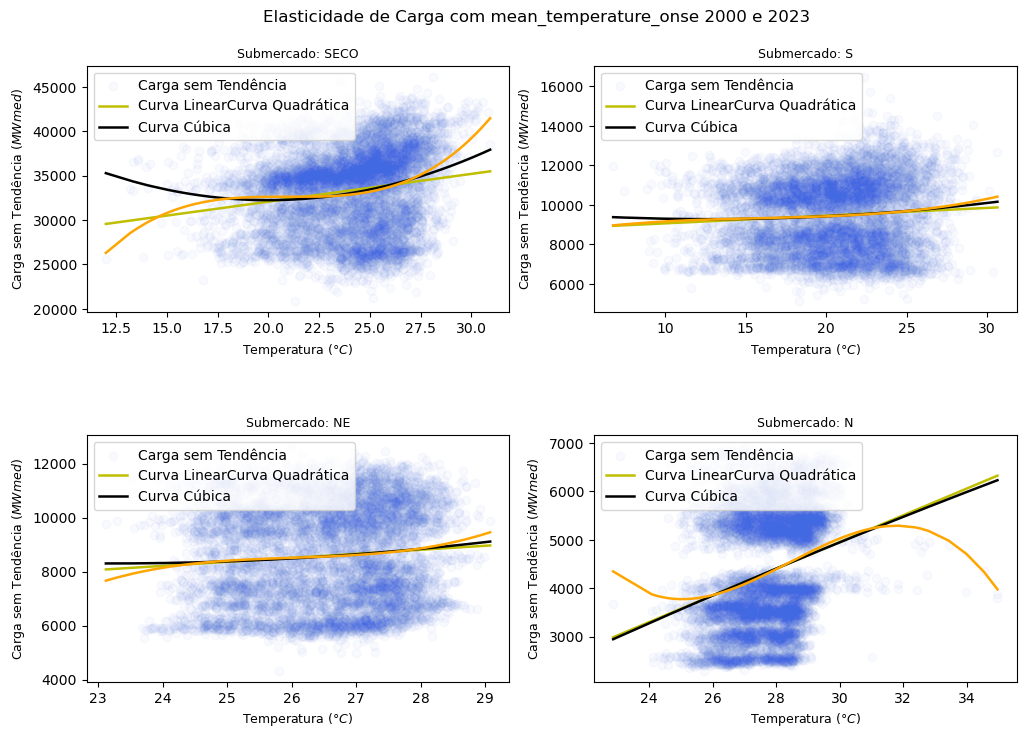

In [22]:
lista_reg = [SECO,S,NE,N]
reg_names = ['SECO','S','NE','N']

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8),sharex = False)
plt.subplots_adjust(hspace=0.50)
#plt.subplots_adjust(wspace=0.08)

fig.suptitle("Elasticidade de Carga com mean_temperature_onse 2000 e 2023", fontsize=12, y=0.95)

count=0
 
for i in range(2):

    for j in range(2):

        ax[i,j].scatter(lista_reg[count].mean_temperature_ons,lista_reg[count].P3,color='royalblue',alpha=0.03)  
        ax[i,j].plot(lista_reg[count].mean_temperature_ons,lista_reg[count].Y_pred_lin, linewidth=1.8,color='y')
        ax[i,j].plot(lista_reg[count].mean_temperature_ons,lista_reg[count].Y_pred_quad,linewidth=1.8,color='black')
        ax[i,j].plot(lista_reg[count].mean_temperature_ons,lista_reg[count].Y_pred_cub,linewidth=1.8,color='orange')
        ax[i,j].legend([ 'Carga sem Tendência','Curva Linear''Curva Quadrática','Curva Cúbica'],loc='upper left')
        ax[i,j].set_title( 'Submercado: ' +reg_names[count] ,fontsize=9, loc='center')
            
        
        ax[i,j].set_ylabel('Carga sem Tendência ($MWmed$)',fontsize=9)
        ax[i,j].set_xlabel('Temperatura ($°C$)',fontsize=9) 
               
        count += 1
                
               
        if count == len(lista_reg):
            break
                    
      
    if count == len(lista_reg):
        break


plt.savefig('figs_teste1/mean_temperature_ons.png')